<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Used-Python-Libraries" data-toc-modified-id="Used-Python-Libraries-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Used Python Libraries</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Example-Images" data-toc-modified-id="Example-Images-0.3.1"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Example Images</a></span></li></ul></li><li><span><a href="#Image-Preprocessing" data-toc-modified-id="Image-Preprocessing-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Image Preprocessing</a></span></li><li><span><a href="#Working-with-Image-Data" data-toc-modified-id="Working-with-Image-Data-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Working with Image Data</a></span><ul class="toc-item"><li><span><a href="#Preparing-Data" data-toc-modified-id="Preparing-Data-0.5.1"><span class="toc-item-num">0.5.1&nbsp;&nbsp;</span>Preparing Data</a></span><ul class="toc-item"><li><span><a href="#Feature-Reduction-with-PCA" data-toc-modified-id="Feature-Reduction-with-PCA-0.5.1.1"><span class="toc-item-num">0.5.1.1&nbsp;&nbsp;</span>Feature Reduction with PCA</a></span></li><li><span><a href="#PCA-Reconstruction-Examples" data-toc-modified-id="PCA-Reconstruction-Examples-0.5.1.2"><span class="toc-item-num">0.5.1.2&nbsp;&nbsp;</span>PCA Reconstruction Examples</a></span></li></ul></li></ul></li><li><span><a href="#XGBoost-Modeling---Bayesian-Hyperparameter-Optimization" data-toc-modified-id="XGBoost-Modeling---Bayesian-Hyperparameter-Optimization-0.6"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>XGBoost Modeling - Bayesian Hyperparameter Optimization</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-0.7"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>CNN</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation-with-Image-Preprocessing" data-toc-modified-id="Data-Preparation-with-Image-Preprocessing-0.7.1"><span class="toc-item-num">0.7.1&nbsp;&nbsp;</span>Data Preparation with Image Preprocessing</a></span></li><li><span><a href="#Model-Authoring" data-toc-modified-id="Model-Authoring-0.7.2"><span class="toc-item-num">0.7.2&nbsp;&nbsp;</span>Model Authoring</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-0.7.3"><span class="toc-item-num">0.7.3&nbsp;&nbsp;</span>Data Augmentation</a></span><ul class="toc-item"><li><span><a href="#Understanding-Data-Augmentation" data-toc-modified-id="Understanding-Data-Augmentation-0.7.3.1"><span class="toc-item-num">0.7.3.1&nbsp;&nbsp;</span>Understanding Data Augmentation</a></span></li></ul></li><li><span><a href="#Testing-the-Network" data-toc-modified-id="Testing-the-Network-0.7.4"><span class="toc-item-num">0.7.4&nbsp;&nbsp;</span>Testing the Network</a></span></li><li><span><a href="#Training-the-Model" data-toc-modified-id="Training-the-Model-0.7.5"><span class="toc-item-num">0.7.5&nbsp;&nbsp;</span>Training the Model</a></span><ul class="toc-item"><li><span><a href="#NOTES---Training-using-PCA..." data-toc-modified-id="NOTES---Training-using-PCA...-0.7.5.1"><span class="toc-item-num">0.7.5.1&nbsp;&nbsp;</span>NOTES - Training using PCA...</a></span></li></ul></li></ul></li><li><span><a href="#Kaggle-Submission" data-toc-modified-id="Kaggle-Submission-0.8"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Kaggle Submission</a></span></li></ul></li><li><span><a href="#NOTES-HERE-BELOW" data-toc-modified-id="NOTES-HERE-BELOW-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NOTES HERE BELOW</a></span><ul class="toc-item"><li><span><a href="#T-SNE---Visualize-to-see-what-hyperparams-work-better" data-toc-modified-id="T-SNE---Visualize-to-see-what-hyperparams-work-better-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>T-SNE - Visualize to see what hyperparams work better</a></span></li><li><span><a href="#T-SNE-Fit" data-toc-modified-id="T-SNE-Fit-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>T-SNE Fit</a></span></li><li><span><a href="#Notes-on-Incremental-Learning" data-toc-modified-id="Notes-on-Incremental-Learning-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Notes on Incremental Learning</a></span></li></ul></li></ul></div>

## Objective

mmmm

[Back to Contents](#Table-of-Contents)

## Used Python Libraries

In [ ]:
# to make sure you use the latest version of kaggle:
!pip install --upgrade --force-reinstall --no-deps kaggle
# with an older version, not all files get downloaded

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Image loading and processing
import os
from PIL import Image
from PIL import Image, ImageDraw

from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import exposure
from skimage import data, img_as_float
import cv2

# Modelng
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# utils
from progressbar import Percentage, ProgressBar,Bar,ETA
import glob
import kaggle

# Hyperparameter optimization
from hyperopt import hp, space_eval, STATUS_OK
import hyperopt
from functools import partial


[Back to Contents](#Table-of-Contents)

## Load Data

A table in csv format is provided to identify the expert diagnosis label and the associated image label.

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
!mkdir data && unzip histopathologic-cancer-detection.zip -d data

In [ ]:
!rm histopathologic-cancer-detection.zip

In [2]:
training_labels_df = pd.read_csv('./data/train_labels.csv')
#training_labels_df = pd.read_csv('train_labels.csv')# in colab
print(training_labels_df.shape)
training_labels_df.sample(6)

(220025, 2)


,id,label
166193,f8addee1df5cea01bbd12c05ca0c89af42ff47e3,0
2570,87483df712c6828644df6d3bdb7f565612ab87d6,0
28350,68c0e2ac82ed9518526f0c8f18f36019362b4023,0
183508,29f97002e0736b81488049f41688b8af3eaedf0d,1
61932,0cf8e28410eb8618234d4b598a9d114e80a734a4,0
169682,e777dbf2c99835206306dad32c939127ebcf591a,0


In [6]:
# Any duplicated exemplar?
any(training_labels_df.duplicated())

False

In [7]:
pd.DataFrame({'label': training_labels_df['label'].value_counts(), 
              'label (perc.)': 100*training_labels_df['label'].value_counts()/len(training_labels_df)})

,label,label (perc.)
0,130908,59.496875
1,89117,40.503125


In [3]:
# image location
img_path ="./data/train"
# bounding box where identification neds to happen
ix1, iy1, ix2, iy2 = 47-16, 47-16, 47+16, 47+16

[Back to Contents](#Table-of-Contents)

### Example Images

In [128]:
def plot_rndm_images(label, img_path = "./data/train", rows_cols = (3,3), rnd_state=0):
    nrows, ncols=rows_cols[0], rows_cols[1]
    
    np.random.seed(rnd_state)
    imgs = np.random.choice(training_labels_df.loc[training_labels_df['label']==label]['id'].values, 
                            size=np.prod(rows_cols))
    fig,ax = plt.subplots(nrows,ncols,figsize=(10,10))
    fig.suptitle('Examples of Label=' + str(label) + ' Images', fontsize=25)
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(imgs[:nrows*ncols]):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='red') # each image has 96pxx96px
        idcol.rectangle(((ix1,iy1),(ix2,iy2)),outline='green')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')  

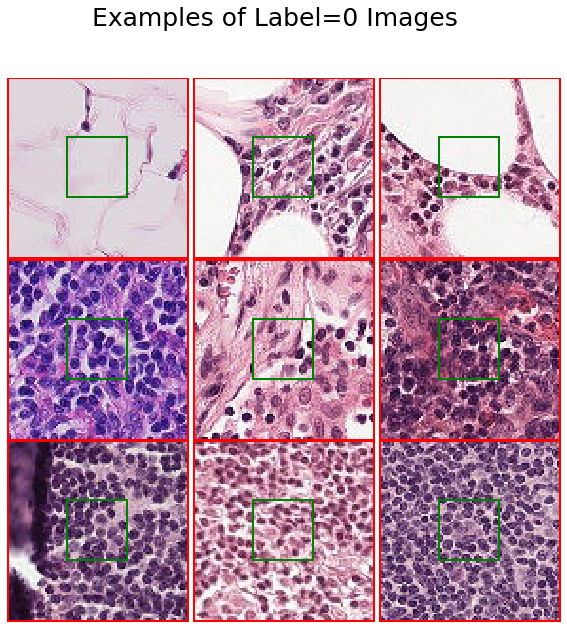

In [129]:
plot_rndm_images(0)

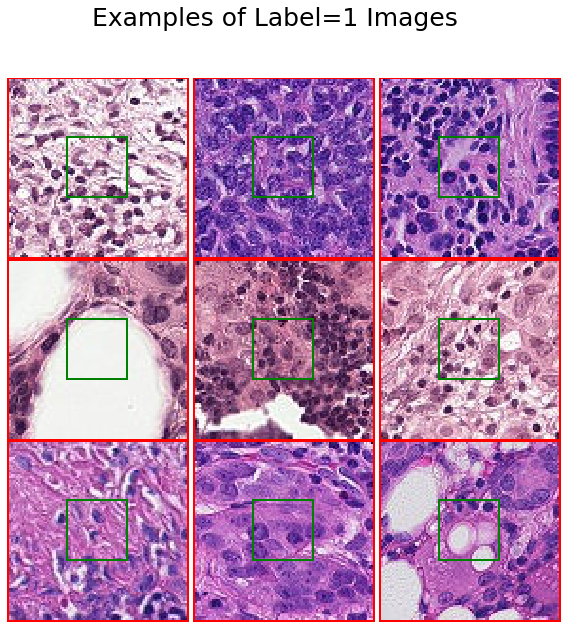

In [130]:
plot_rndm_images(1)

[Back to Contents](#Table-of-Contents)

## Image Preprocessing

1. Gaussian Filter for noise removal (https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise_wavelet.html)
2. Contrast enhancement (https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html). Thee equalized image has roughly linear cumulative distribution. As you can see there is a lot of noise in the above image, because it considers the global contrast of the image, not just the local contrast.


Estimated Gaussian noise standard deviation = 0.4384843140864356


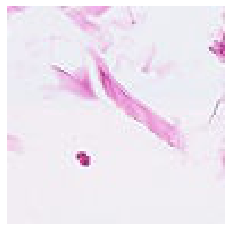

In [63]:
imgs_0 = np.array(Image.open(os.path.join(img_path,
                                 np.random.choice(training_labels_df.loc[training_labels_df['label']==0]['id'].values, size=1)[0]) +'.tif'))

plt.imshow(np.array(imgs_0))
plt.axis('off')  
        
# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(imgs_0, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

(-0.5, 95.5, 95.5, -0.5)

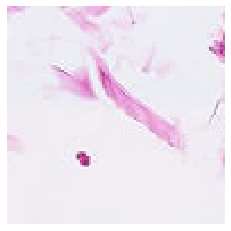

In [64]:
# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  
im_visushrink = denoise_wavelet(imgs_0, multichannel=True, convert2ycbcr=True,
                                method='VisuShrink', mode='soft',
                                sigma=sigma_est, rescale_sigma=True)
plt.imshow(np.array(im_visushrink))
plt.axis('off')  

(-0.5, 95.5, 95.5, -0.5)

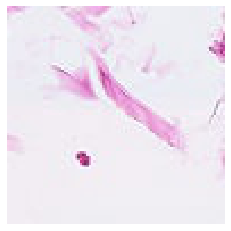

In [65]:
im_bayes = denoise_wavelet(imgs_0, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

plt.imshow(np.array(im_bayes))
plt.axis('off')  

(-0.5, 95.5, 95.5, -0.5)

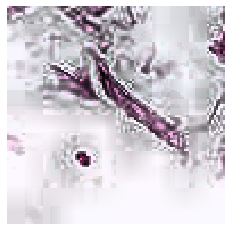

In [96]:
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(im_bayes, clip_limit=0.03)

plt.imshow(np.array(img_adapteq))
plt.axis('off')  

CLAHE gives a much better result (see below) compared to the normal equalized image (above). However, we neeed to remove some inttroduced nois. We'll use thresholding.

(-0.5, 95.5, 95.5, -0.5)

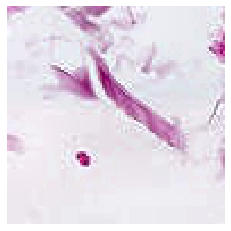

In [113]:
# CLAHE applies to gray scale images 
# Conversion of RGB to LAB(L for lightness and a and b for the color opponents green–red and blue–yellow) 
# will do the work. Apply CLAHE to the converted image in LAB format to only Lightness component and convert 
# back the image to RGB. 

norm_image = cv2.normalize(im_bayes, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)

lab = cv2.cvtColor(norm_image, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(4,4))
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv2.merge(lab_planes)
bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

plt.imshow(np.array(bgr))
plt.axis('off')  

(-0.5, 95.5, 95.5, -0.5)

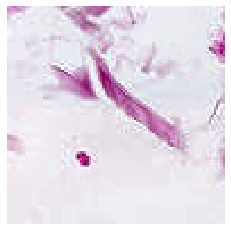

In [114]:
# remove noise using thresholding
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
ret, thresh = cv2.threshold(lab_planes[0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lab = cv2.merge(lab_planes)
bgr_1 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

plt.imshow(np.array(bgr_1))
plt.axis('off')  

In [50]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

Text(0.5, 1.0, 'CLAHE+THRESH')

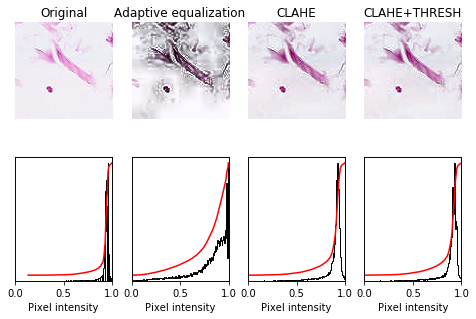

In [118]:
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2,4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(imgs_0, axes[:, 0])
ax_img.set_title('Original')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 1])
ax_img.set_title('Adaptive equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(bgr, axes[:, 2])
ax_img.set_title('CLAHE')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(bgr_1, axes[:, 3])
ax_img.set_title('CLAHE+THRESH')

In [161]:
def plot_rndm_images(label, proc = False, img_path = "./data/train", rows_cols = (3,3), rnd_state=0):
    nrows, ncols=rows_cols[0], rows_cols[1]
    
    np.random.seed(rnd_state)
    imgs = np.random.choice(training_labels_df.loc[training_labels_df['label']==label]['id'].values, 
                            size=np.prod(rows_cols))
    fig,ax = plt.subplots(nrows,ncols,figsize=(10,10))
    if proc:
        fig.suptitle('Examples of Label=' + str(label) + ' Preprocessed Images', fontsize=25)
    else:
        fig.suptitle('Examples of Label=' + str(label) + ' Images', fontsize=25)
        
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(imgs[:nrows*ncols]):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        
        if proc:
            # Estimate the average noise standard deviation across color channels and 
            # remove Gaussian noise
            sigma_est = estimate_sigma(np.array(img), multichannel=True, average_sigmas=True)
            img_proc = denoise_wavelet(np.array(img), multichannel=True, convert2ycbcr=True,
                               method='BayesShrink', mode='soft',
                               rescale_sigma=True)
            # Contrast enhancement - CLAHE - Gray scale image is needed
            ## normalize to 0-255
            img_proc = cv2.normalize(img_proc, None, alpha = 0, beta = 255, 
                                       norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            img_proc = img_proc.astype(np.uint8)
            ## grey scale
            lab = cv2.cvtColor(img_proc, cv2.COLOR_BGR2LAB)
            lab_planes = cv2.split(lab)
            ## CLAHE
            clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(4,4))
            lab_planes[0] = clahe.apply(lab_planes[0])
            #lab = cv2.merge(lab_planes)
            #img_proc = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            # Theshold based noise removal
            #lab = cv2.cvtColor(img_proc, cv2.COLOR_BGR2LAB)
            #lab_planes = cv2.split(lab)
            ret, thresh = cv2.threshold(lab_planes[0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            lab = cv2.merge(lab_planes)
            img_proc = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            # convert to 0, 255 scale for plotting
            img_proc = cv2.normalize(img_proc, None, alpha = 0, beta = 255, 
                                       norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            img_proc = img_proc.astype(np.uint8)
        
            img = Image.fromarray(img_proc)
            
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='red') # each image has 96pxx96px
        idcol.rectangle(((ix1,iy1),(ix2,iy2)),outline='green')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')  

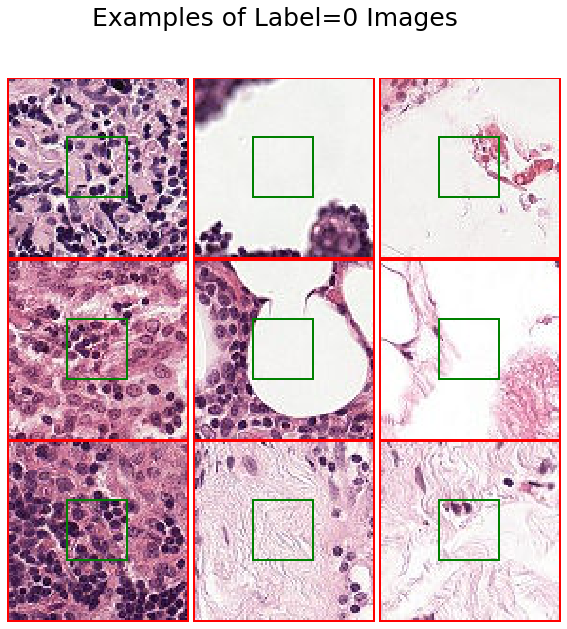

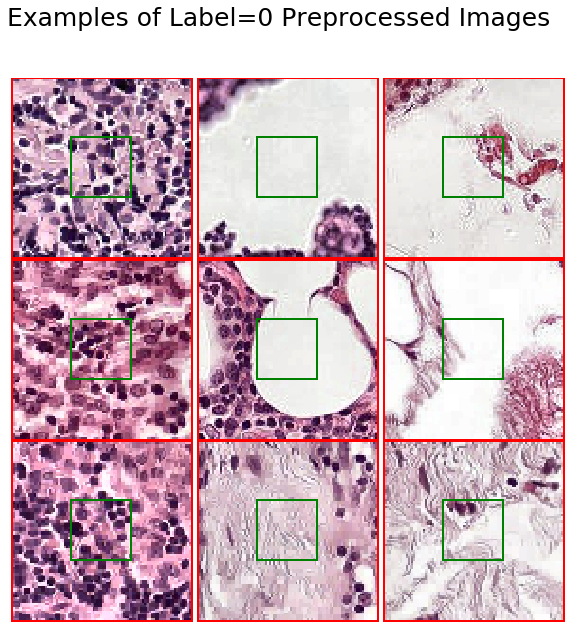

In [163]:
plot_rndm_images(0,False, rnd_state=2)
plot_rndm_images(0, True, rnd_state=2)

## Working with Image Data

In [150]:
print('An image can be converted to an array of size:', 
      np.array(Image.open(os.path.join(img_path ,training_labels_df.iloc[0]['id'] +'.tif'))).shape)


An image can be converted to an array of size: (96, 96, 3)


Let's take two random images, one with label=1 and the other with label=0. Can we separate them ...?

In [151]:
np.random.seed(1)

imgs_0 = np.array(Image.open(os.path.join(img_path ,
                                          np.random.choice(training_labels_df.loc[training_labels_df['label']==0]['id'].values, size=1)[0]) +'.tif'))

imgs_1 = np.array(Image.open(os.path.join(img_path ,
                                          np.random.choice(training_labels_df.loc[training_labels_df['label']==1]['id'].values, size=1)[0]) +'.tif'))


In [152]:
np.ravel(imgs_0[ix1:ix2,iy1:iy2,1]).shape, np.ravel(imgs_1[ix1:ix2,iy1:iy2,1]).shape

print('When we consider the central part of the image of size', ix2-ix1, 'px X', iy2-iy1, 'px',
     'the size of one exemplar becomes', np.ravel(imgs_0[ix1:ix2,iy1:iy2,1]).shape)

When we consider the central part of the image of size 32 px X 32 px the size of one exemplar becomes (1024,)


### Preparing Data

In [4]:
def preproc_img(img):
    
    # Estimate the average noise standard deviation across color channels and 
    # remove Gaussian noise
    sigma_est = estimate_sigma(img, multichannel=True, average_sigmas=True)
    img_proc = denoise_wavelet(img, multichannel=True, convert2ycbcr=True,
                               method='BayesShrink', mode='soft',
                               rescale_sigma=True)
    # Contrast enhancement - CLAHE - Gray scale image is needed
    ## 0-255 array
    img_proc = cv2.normalize(img_proc, None, alpha = 0, beta = 255, 
                             norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img_proc = img_proc.astype(np.uint8)
    ## grey scale
    lab = cv2.cvtColor(img_proc, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(4,4))
    lab_planes[0] = clahe.apply(lab_planes[0])
    # Theshold based noise removal - grey scale is needed
    ret, thresh = cv2.threshold(lab_planes[0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ## back to color scale
    lab = cv2.merge(lab_planes)
    img_proc = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # convert to 0, 255 scale 
    img_proc = cv2.normalize(img_proc, None, alpha = 0, beta = 255, 
                             norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img_proc = img_proc.astype(np.uint8)
        
    return img

In [5]:
def getBatchData(img_path, img_names, verbose=False):
    imgs_np = []
    if verbose:
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                           maxval=len(img_names)).start()
    k = 0
    for i,j in enumerate(img_names):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        img_arr = np.array(img)
        img_arr = preproc_img(img_arr)
        imgs_np.append(np.ravel(img_arr[ix1:ix2,iy1:iy2,:])[:,None]/255.)
        k += 1
        if verbose:
            pbar.update(k)
    if verbose:
        pbar.finish()

    imgs_np = np.hstack(imgs_np).T
    
    return imgs_np

In [6]:
train_labels_df, test_labels_df = train_test_split(training_labels_df, test_size=0.25, 
                                                   stratify=training_labels_df.label, random_state=10)

train_labels_df.shape, test_labels_df.shape

((165018, 2), (55007, 2))

In [184]:
%%time

img_names = test_labels_df['id'].values
X_test = getBatchData("./data/train", img_names, verbose=True)
y_test = test_labels_df['label'].values   

X_test.shape

/Users/atambu310/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/atambu310/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/atambu310/anaconda3/lib/python3.7/site-packages/skimage/restoration/_denoise.py:643: RuntimeWarning: invalid value encountered in double_scalars
  scale_factor = range_post / range_pre
[==========================================================] 100% Time: 0:07:44


CPU times: user 6min 47s, sys: 25 s, total: 7min 12s
Wall time: 7min 46s


(55007, 3072)

In [185]:
%%time

img_names = train_labels_df['id'].values
X_train = getBatchData("./data/train", img_names, verbose=True)
y_train = train_labels_df['label'].values

X_train.shape

[==========================================================] 100% Time: 0:23:54


CPU times: user 20min 26s, sys: 1min 31s, total: 21min 57s
Wall time: 24min 17s


(165018, 3072)

#### Feature Reduction with PCA

We can use PCA to reduce the number of dimensions to a more reasonable amount of features

In [186]:
pca_pipeline = make_pipeline(StandardScaler(), PCA(0.95, random_state=2)) 
components = pca_pipeline.fit_transform(X_train)
print('original shape:', X_train.shape)
print('after PCA (95%)', components.shape)

original shape: (165018, 3072)
after PCA (95%) (165018, 700)


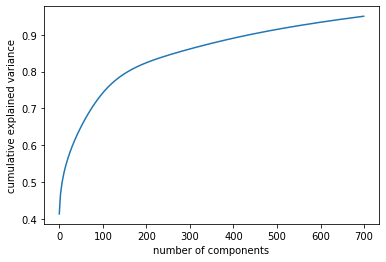

In [187]:
plt.plot(np.cumsum(pca_pipeline['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [189]:
components_test = pca_pipeline.transform(X_test)

#### PCA Reconstruction Examples

In [190]:
weights = compute_class_weight('balanced', np.unique(y_train), y_train)

# assign same probability to the two labels
p_0 = weights[0]
p_1 = weights[1]
p_s = np.array([p_0 if i==0 else p_1 for i in y_train])
p_s = p_s/np.sum(p_s)

# random sample of images
n_imgs = 1000 # limit for visualization
np.random.seed(1)
lbls_i_s = np.random.choice(range(len(train_labels_df['id'].values)), 
                          p = p_s,
                          size=n_imgs)

print('labels (counts):', np.unique(y_train[lbls_i_s], return_counts=True)[1])

labels (counts): [497 503]


/Users/atambu310/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


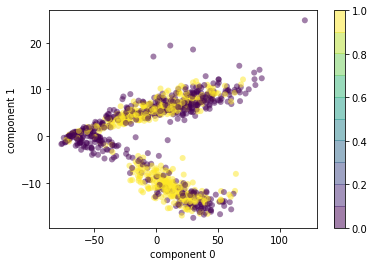

In [191]:
comps = (0,1)

plt.scatter(components[lbls_i_s, comps[0]], components[lbls_i_s, comps[1]],
            c=y_train[lbls_i_s], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component '+str(comps[0]))
plt.ylabel('component '+str(comps[1]))
plt.colorbar();

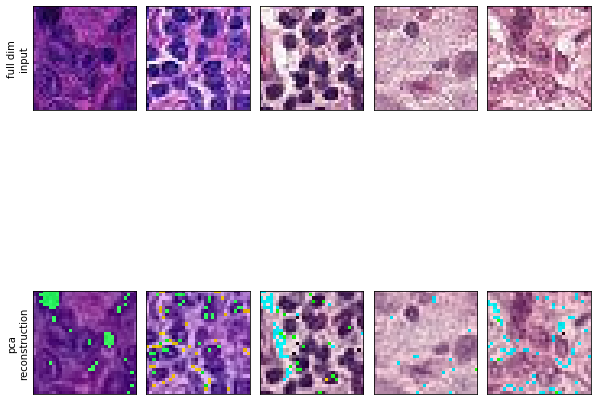

In [192]:
# Plot the PCA reconstruction
n_show = 5
projected = pca_pipeline.inverse_transform(components[lbls_i_s,:]) #reconstructed from components

fig, ax = plt.subplots(2, 5, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(n_show):

    ax[0, i].imshow((255*X_train[lbls_i_s,:][i,:]).astype('uint8').reshape(32,32,3), cmap='binary_r')
    ax[1, i].imshow((255*projected[i]).astype('uint8').reshape(32,32,3), cmap='binary_r')
    
ax[0, 0].set_ylabel('full dim\ninput')
ax[1, 0].set_ylabel('pca\nreconstruction');


[Back to Contents](#Table-of-Contents)

## XGBoost Modeling - Bayesian Hyperparameter Optimization


In [195]:
def objective(space):
    
    print(space)
    
    # we use 10% of data to search the best parameters
    n_imgs = int(len(components)*0.1) 
    
    np.random.seed(1)
    lbls_i_s = np.random.choice(range(len(components)), 
                              p = p_s,
                              size=n_imgs)
    
    num_round = int(space['n_estimators'])
    dtrain = xgb.DMatrix(components[lbls_i_s,:], label=y_train[lbls_i_s])
    dvalid = xgb.DMatrix(components_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm_model = xgb.train(space, dtrain, 
                          num_boost_round=num_round,
                          evals=watchlist,
                          early_stopping_rounds =10, 
                          verbose_eval=False)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    # Hyperopt minimizes...
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


space = {
    'n_estimators': hp.choice('n_estimators', [1000]),#hp.quniform('n_estimators', 100, 1000, 1)
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate':  hp.choice('learning_rate', [0.001, 0.01, 0.1, 1]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda': hp.choice('reg_lambda', [0,1,10,100,1000]),#l2
    'gamma': hp.choice('gamma', [0,1,10,100,1000]), #l1
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    # Increase this number if you have more cores. Otherwise, remove it and it will default 
    # to the maxium number. 
    'nthread': 4,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': 0,
    
}


# Object stores all information about each trial.
# Also, it stores information about the best trial.
trials = hyperopt.Trials()

tpe = partial(
    hyperopt.tpe.suggest,

    # Sample 1000 candidate and select candidate that
    # has highest Expected Improvement
    n_EI_candidates=1000,

    # Use 20% of best observations to estimate next
    # set of parameters
    gamma=0.2,

    # First 20 trials are going to be random
    n_startup_jobs=20
)

best_trial = hyperopt.fmin(
    objective,

    trials=trials,
    space=space,

    # Set up TPE for hyperparameter optimization
    algo=tpe,

    # Maximum number of iterations. Basically it trains at
    # most 200 networks before selecting the best one.
    max_evals=100
)

{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 100, 'learning_rate': 1, 'max_depth': 6, 'min_child_weight': 2.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 0.5, 'tree_method': 'exact'}
[15:37:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.7802333750746546                            


{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 5.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 1000, 'seed': 0, 'silen

	Score 0.82118113813426                                                        


{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.05, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 0.8, 'tree_method': 'exact'}
[15:41:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:       
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.8099731064984089                                                      


{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.125, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 1, 'max_dep

[15:43:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:       
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.8549824018830717                                                      


{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.025, 'eval_metric': 'auc', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 10, 'seed': 0, 'silent': 1, 'subsample': 1.0, 'tree_method': 'exact'}
[15:46:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:          
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p

	Score 0.855703469631447                                                           


{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 5.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 1, 'seed': 0, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
[16:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:           
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.8541763230158377                                                          


{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.25, 'eval_metric': 'auc', 'gamma': 1, 'learning_rat

[20:08:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:               
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.7282017339297695                                                              


{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.375, 'eval_metric': 'auc', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
[20:08:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:               
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are o

	Score 0.802713775607017                                                             


{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.47500000000000003, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 1, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
[20:29:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:             
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.7757661101394875                                                            


{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.4, 'eval_metric': 'auc', 'gamma': 1000, 'learnin

[20:52:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:             
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.8041765938763633                                                            


{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.4, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 0.001, 'max_depth': 13, 'min_child_weight': 1.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 100, 'seed': 0, 'silent': 1, 'subsample': 0.65, 'tree_method': 'exact'}
[20:52:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:             
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in langu

	Score 0.8505065420977052                                                            


{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.17500000000000002, 'eval_metric': 'auc', 'gamma': 100, 'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 1000, 'seed': 0, 'silent': 1, 'subsample': 0.7000000000000001, 'tree_method': 'exact'}
[21:28:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:             
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.7606159888131723                                                            


{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.4, 'eval_metric': 'auc', '

[21:54:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:         
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.7687200109397481                                                        


{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 0.65, 'tree_method': 'exact'}
[21:54:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:         
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

	Score 0.864721482144408                                                           


{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
[22:39:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541:           
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.85587300226305                                                            


{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'auc', 'gamma': 0, 'learning_rat

In [196]:
param_dist = space_eval(space, best_trial)
param_dist

{'booster': 'gbtree',
 'colsample_bytree': 0.9,
 'eta': 0.225,
 'eval_metric': 'auc',
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 9,
 'min_child_weight': 6.0,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_lambda': 0,
 'seed': 0,
 'silent': 1,
 'subsample': 0.75,
 'tree_method': 'exact'}

In [197]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

trials_results = {}
trials_vals = {}
trials_nodes = {}
for i in range(len(trials.trials)):
    trials_results[i] = trials.trials[i]['result']['loss']
    trials_vals[i] = trials.trials[i]['misc']['vals']
    pp.pprint(trials.trials[i]["result"])

{'loss': 0.21976662492534538, 'status': 'ok'}
{'loss': 0.19869712589964772, 'status': 'ok'}
{'loss': 0.20173690717819626, 'status': 'ok'}
{'loss': 0.1558330232494607, 'status': 'ok'}
{'loss': 0.20590699285899194, 'status': 'ok'}
{'loss': 0.24661948235166076, 'status': 'ok'}
{'loss': 0.20639694800668318, 'status': 'ok'}
{'loss': 0.20489731602042216, 'status': 'ok'}
{'loss': 0.2950271879509828, 'status': 'ok'}
{'loss': 0.2292637026214197, 'status': 'ok'}
{'loss': 0.17881886186574003, 'status': 'ok'}
{'loss': 0.19002689350159108, 'status': 'ok'}
{'loss': 0.22979008336689266, 'status': 'ok'}
{'loss': 0.16981450415188726, 'status': 'ok'}
{'loss': 0.20276053916248227, 'status': 'ok'}
{'loss': 0.1939922682828661, 'status': 'ok'}
{'loss': 0.21292721493554845, 'status': 'ok'}
{'loss': 0.15659430384291695, 'status': 'ok'}
{'loss': 0.21407082921831067, 'status': 'ok'}
{'loss': 0.24076065329419327, 'status': 'ok'}
{'loss': 0.292193059755151, 'status': 'ok'}
{'loss': 0.14501759811692827, 'status': 

In [199]:
dtrain = xgb.DMatrix(components, label=y_train)
dvalid = xgb.DMatrix(components_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm_model = xgb.train(param_dist, 
                      dtrain, 
                      num_boost_round = int(param_dist['n_estimators']),
                      evals=watchlist,
                      early_stopping_rounds =10, 
                      verbose_eval=True)

[00:46:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.84036	eval-auc:0.81392
[1]	train-auc:0.85225	eval-auc:0.82612
[2]	train-auc:0.85551	eval-auc:0.82940
[3]	train-auc:0.85843	eval-auc:0.83321
[4]	train-auc:0.85984	eval-auc:0.83464
[5]	train-auc:0.86105	eval-auc:0.83569
[6]	train-auc:0.86311	eval-auc:0.83702
[7]	train-auc:0.86386	eval-auc:0.83787
[8]	train-auc:0.86452	eval-auc:0.83852
[9]	train-auc:0.86635	eval-auc:0.83990
[10]	train-auc:0.86656	eval-auc:0.84017
[11]	train-auc:0.86687	eval-auc:0.84049
[12]	train-auc:0.86711	eval-auc:0.84084
[13]	train-auc:0.86730	eval-auc:0.84109
[14]	train-auc:0.86799	eval-auc:0.84150
[15]	train-auc:0.86814	eval-auc:0.84166


[194]	train-auc:0.89858	eval-auc:0.85855
[195]	train-auc:0.89871	eval-auc:0.85864
[196]	train-auc:0.89883	eval-auc:0.85871
[197]	train-auc:0.89897	eval-auc:0.85878
[198]	train-auc:0.89909	eval-auc:0.85885
[199]	train-auc:0.89923	eval-auc:0.85891
[200]	train-auc:0.89936	eval-auc:0.85899
[201]	train-auc:0.89949	eval-auc:0.85905
[202]	train-auc:0.89963	eval-auc:0.85911
[203]	train-auc:0.89977	eval-auc:0.85919
[204]	train-auc:0.89990	eval-auc:0.85925
[205]	train-auc:0.90005	eval-auc:0.85931
[206]	train-auc:0.90018	eval-auc:0.85938
[207]	train-auc:0.90033	eval-auc:0.85945
[208]	train-auc:0.90044	eval-auc:0.85952
[209]	train-auc:0.90056	eval-auc:0.85958
[210]	train-auc:0.90070	eval-auc:0.85961
[211]	train-auc:0.90083	eval-auc:0.85968
[212]	train-auc:0.90097	eval-auc:0.85973
[213]	train-auc:0.90109	eval-auc:0.85977
[214]	train-auc:0.90122	eval-auc:0.85982
[215]	train-auc:0.90136	eval-auc:0.85990
[216]	train-auc:0.90148	eval-auc:0.85997
[217]	train-auc:0.90163	eval-auc:0.86003
[218]	train-auc:

[394]	train-auc:0.92018	eval-auc:0.86881
[395]	train-auc:0.92024	eval-auc:0.86884
[396]	train-auc:0.92033	eval-auc:0.86887
[397]	train-auc:0.92040	eval-auc:0.86892
[398]	train-auc:0.92049	eval-auc:0.86897
[399]	train-auc:0.92058	eval-auc:0.86902
[400]	train-auc:0.92066	eval-auc:0.86904
[401]	train-auc:0.92073	eval-auc:0.86908
[402]	train-auc:0.92081	eval-auc:0.86911
[403]	train-auc:0.92090	eval-auc:0.86916
[404]	train-auc:0.92097	eval-auc:0.86920
[405]	train-auc:0.92105	eval-auc:0.86923
[406]	train-auc:0.92112	eval-auc:0.86926
[407]	train-auc:0.92119	eval-auc:0.86928
[408]	train-auc:0.92129	eval-auc:0.86934
[409]	train-auc:0.92136	eval-auc:0.86938
[410]	train-auc:0.92146	eval-auc:0.86941
[411]	train-auc:0.92153	eval-auc:0.86944
[412]	train-auc:0.92162	eval-auc:0.86949
[413]	train-auc:0.92169	eval-auc:0.86952
[414]	train-auc:0.92176	eval-auc:0.86956
[415]	train-auc:0.92185	eval-auc:0.86959
[416]	train-auc:0.92194	eval-auc:0.86963
[417]	train-auc:0.92201	eval-auc:0.86966
[418]	train-auc:

[594]	train-auc:0.93614	eval-auc:0.87540
[595]	train-auc:0.93624	eval-auc:0.87545
[596]	train-auc:0.93631	eval-auc:0.87547
[597]	train-auc:0.93637	eval-auc:0.87550
[598]	train-auc:0.93644	eval-auc:0.87552
[599]	train-auc:0.93652	eval-auc:0.87555
[600]	train-auc:0.93661	eval-auc:0.87556
[601]	train-auc:0.93667	eval-auc:0.87559
[602]	train-auc:0.93672	eval-auc:0.87560
[603]	train-auc:0.93679	eval-auc:0.87562
[604]	train-auc:0.93685	eval-auc:0.87564
[605]	train-auc:0.93692	eval-auc:0.87566
[606]	train-auc:0.93698	eval-auc:0.87570
[607]	train-auc:0.93706	eval-auc:0.87573
[608]	train-auc:0.93714	eval-auc:0.87577
[609]	train-auc:0.93720	eval-auc:0.87578
[610]	train-auc:0.93725	eval-auc:0.87579
[611]	train-auc:0.93732	eval-auc:0.87583
[612]	train-auc:0.93737	eval-auc:0.87584
[613]	train-auc:0.93744	eval-auc:0.87587
[614]	train-auc:0.93752	eval-auc:0.87589
[615]	train-auc:0.93759	eval-auc:0.87591
[616]	train-auc:0.93768	eval-auc:0.87596
[617]	train-auc:0.93775	eval-auc:0.87596
[618]	train-auc:

[794]	train-auc:0.94839	eval-auc:0.87950
[795]	train-auc:0.94845	eval-auc:0.87951
[796]	train-auc:0.94850	eval-auc:0.87952
[797]	train-auc:0.94858	eval-auc:0.87953
[798]	train-auc:0.94862	eval-auc:0.87954
[799]	train-auc:0.94868	eval-auc:0.87955
[800]	train-auc:0.94874	eval-auc:0.87957
[801]	train-auc:0.94878	eval-auc:0.87958
[802]	train-auc:0.94887	eval-auc:0.87963
[803]	train-auc:0.94892	eval-auc:0.87964
[804]	train-auc:0.94898	eval-auc:0.87967
[805]	train-auc:0.94903	eval-auc:0.87967
[806]	train-auc:0.94908	eval-auc:0.87970
[807]	train-auc:0.94911	eval-auc:0.87971
[808]	train-auc:0.94916	eval-auc:0.87971
[809]	train-auc:0.94922	eval-auc:0.87973
[810]	train-auc:0.94926	eval-auc:0.87974
[811]	train-auc:0.94928	eval-auc:0.87975
[812]	train-auc:0.94934	eval-auc:0.87978
[813]	train-auc:0.94938	eval-auc:0.87979
[814]	train-auc:0.94942	eval-auc:0.87981
[815]	train-auc:0.94946	eval-auc:0.87982
[816]	train-auc:0.94953	eval-auc:0.87985
[817]	train-auc:0.94958	eval-auc:0.87985
[818]	train-auc:

[994]	train-auc:0.95735	eval-auc:0.88225
[995]	train-auc:0.95736	eval-auc:0.88226
[996]	train-auc:0.95739	eval-auc:0.88226
[997]	train-auc:0.95745	eval-auc:0.88228
[998]	train-auc:0.95751	eval-auc:0.88232
[999]	train-auc:0.95753	eval-auc:0.88233


In [200]:
predictions = gbm_model.predict(dvalid,
                                ntree_limit=gbm_model.best_iteration + 1)
score = roc_auc_score(y_test, predictions)
print("\tScore {0}\n\n".format(score))

	Score 0.882326023610041




In [54]:
import pickle

# save the model to disk
filename = 'gbm_model.sav'
pickle.dump(gbm_model, open(filename, 'wb'))
 

In [ ]:
# load the model from disk
filename = 'gbm_model.sav'
gbm_model = pickle.load(open(filename, 'rb'))

## CNN

According to this [paper](https://papers.nips.cc/paper/2019/file/eb1e78328c46506b46a4ac4a1e378b91-Paper.pdf):
"transfer learning offers limited performance gains and much smaller architectures can perform
comparably to the standard IMAGENET models". However, substantial gain in terms of speeding the computation arises when "Use the pretrained weights only from the lowest two layers. The rest of the network is randomly initialized and fine-tuned for the medical imaging task." (see [here](https://theaisummer.com/medical-imaging-transfer-learning/) for example)

In [ ]:
#!pip install -U efficientnet
# https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [7]:
from keras.applications import vgg16 
import efficientnet.keras as efn

#from keras.applications.vgg16 import decode_predictions
#from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.imagenet_utils import preprocess_input
#from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.backend import clear_session

from keras.optimizers import Adam

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras import Model, Sequential

from keras.models import load_model, save_model 

from keras.preprocessing.image import ImageDataGenerator


### Data Preparation with Image Preprocessing

In [8]:
def prepImageData(img_path, img_names, verbose=False):        
        
    imgs = []
    if verbose:
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                           maxval=len(img_names)).start()
    k = 0
    for i,j in enumerate(img_names):
        fname = os.path.join(img_path ,j +'.tif')
        img = np.asarray(Image.open(fname), dtype=np.float32) # for drawing
        img = preproc_img(img)
        # reusing pretrained models with pooling requires a minumum number of pixels.
        # we keep all pixels but we set those outside of the interest region to 0
        #img = img.copy() # without cpying I can't crop...
        #img[:ix1,:,:] = 0. 
        #img[:,:iy1,:] = 0. 
        #img[ix2:,:,:] = 0. 
        #img[:,iy2:,:] = 0. 
        imgs.append(img[None,ix1:ix2,iy1:iy2,:]/255.)
        #imgs.append(img[None,:,:,:]/255.)# None needed to keep first dimension when concatenating
        k += 1
        if verbose:
            pbar.update(k)
    if verbose:
        pbar.finish()

    #imgs_np = preprocess_input(imgs)
    imgs_np = np.concatenate(imgs, axis=0)
    
    return imgs_np

In [ ]:
#NOTES:
#Image.fromarray(X_train[0], 'RGB') #must be np.int8 to draw and not normalized if you want to check cropping
#plt.imshow(np.array(Image.open(os.path.join(img_path ,img_names[0] +'.tif'))))

In [9]:
img_names = train_labels_df['id'].values

X_train = prepImageData("./data/train", img_names, verbose=True)
X_train.shape

/Users/atambu310/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/atambu310/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/atambu310/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
[==========================================================] 100% Time: 0:23:25


(165018, 32, 32, 3)

In [10]:
img_names = test_labels_df['id'].values

X_test = prepImageData("./data/train", img_names, verbose=True)
X_test.shape

[==========================================================] 100% Time: 0:07:35


(55007, 32, 32, 3)

In [14]:
y_train = train_labels_df['label'].values   
y_test = test_labels_df['label'].values   


### Model Authoring

[EfficientNet fine tuning](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

In [334]:
# original model
base_model = efn.EfficientNetB0(weights='imagenet', #using pre-trained weights
                       )
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

The EFN model was trained to classify 1000 different images. We remove the classification/softmax layer containing 1000 units. Also, the input needs to accept our input format. 

In [32]:
clear_session()
base_model = efn.EfficientNetB0(weights='imagenet', #using pre-trained weights
                        input_shape=(32, 32, 3),
                        include_top=False # rm thee last fully connected layer
                       )

# make layers non-trainable except...
for layer in base_model.layers:
    layer.trainable = False

# the top layers, which we rebuild here
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
# we could add more dense, dropout layers here
#x = Dense(1024, activation="relu")(x)
#x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid", name="pred")(x) 

custom_base_model = Model(base_model.input, out)

# print the layers of the CNN
custom_base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 16, 16, 32)   0           stem_bn[0][0]                    
_______________________________________________________________________________________

### Data Augmentation

The network has 4M+ parameters, so we need to augment the data using a generator.

In [12]:
# Create a Data Generator
data_gen_args = dict( 
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)
image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)

#### Understanding Data Augmentation

Epoch 0
(6, 32, 32, 3)


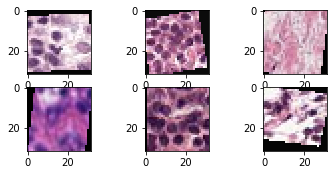

[0 0 0 1 0 0]
Epoch 1
(6, 32, 32, 3)


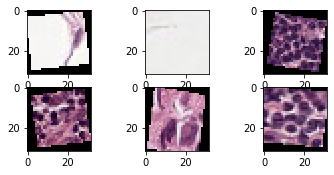

[0 0 0 0 1 0]
Epoch 2
(6, 32, 32, 3)


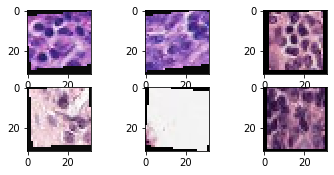

[0 1 0 0 0 0]
Epoch 3
(6, 32, 32, 3)


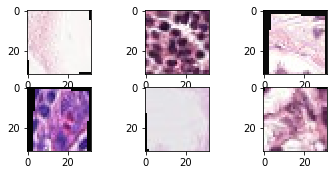

[0 0 1 0 0 1]
Epoch 4
(6, 32, 32, 3)


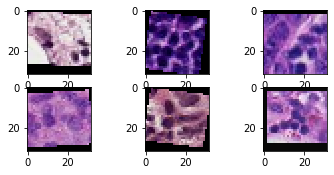

[1 0 1 1 1 1]


In [291]:
aug_batch_size = 6
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in image_datagen.flow(X_train, y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        

        plt.show()
        print(y_batch)
        break

### Testing the Network

In [ ]:
# for testing purposes, sample fewer images
i_s, _ = train_test_split(np.arange(0,len(y_train)), train_size=1000,
                          stratify=y_train, random_state=10)

i_s1, _ = train_test_split(np.arange(0,len(y_test)), train_size=1000,
                          stratify=y_test, random_state=20)

print(np.unique(y_train[i_s], return_counts=True), np.unique(y_test[i_s1], return_counts=True))

custom_base_model.compile(loss="binary_crossentropy", optimizer=Adam(), 
                         metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, 
                   restore_best_weights=True, 
                   patience=10)
                
n_epochs = 50
batch_size = 512
custom_base_model_history = custom_base_model.fit(image_datagen.flow(X_train[i_s], 
                                                                     y_train[i_s], 
                                                                     batch_size=batch_size),
                                                  steps_per_epoch=len(X_train[i_s]) / batch_size, 
                                                  validation_data=(X_test[i_s1], y_test[i_s1]),
                                                  epochs=n_epochs, callbacks=[es])

#custom_base_model_history = custom_base_model.fit(X_train[i_s], 
#                                                y_train[i_s],
#                                                validation_data=(X_test[i_s1], y_test[i_s1]),
#                                                batch_size = batch_size,
#                                                epochs=n_epochs, callbacks=[es])

### Training the Model

1. Train with all layers frozen except the classification (top) layers.
2. Unfreeze 20 layers at the time and reduce learning rate

During fine tuning (from keras notes):
1. The BathcNormalization layers need to be kept frozen (more details). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.
2. In some cases it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.
3. Each block needs to be all turned on or off. This is because the architecture includes a shortcut from the first layer to the last layer for each block. Not respecting blocks also significantly harms the final performance.

In [33]:
custom_base_model.compile(loss="binary_crossentropy", optimizer=Adam(), 
                         metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, 
                   restore_best_weights=True, 
                   patience=10)
                
batch_size = 32
n_epochs = 10
#custom_base_model_history = custom_base_model.fit(X_train, 
#                                                y_train,
#                                                validation_data=(X_test, y_test),
#                                                batch_size = batch_size,
#                                                epochs=n_epochs, callbacks=[es])
custom_base_model_history = custom_base_model.fit(image_datagen.flow(X_train, y_train, 
                                                                     batch_size=batch_size),
                                                  steps_per_epoch=len(X_train) / batch_size, 
                                                  epochs=n_epochs, 
                                                  validation_data=(X_test, y_test), 
                                                  callbacks=[es])


Epoch 1/10
5157/5156 [==============================] - 237s 46ms/step - loss: 0.5368 - accuracy: 0.7430 - val_loss: 0.5419 - val_accuracy: 0.7396
Epoch 2/10
5157/5156 [==============================] - 239s 46ms/step - loss: 0.5231 - accuracy: 0.7515 - val_loss: 0.4955 - val_accuracy: 0.7695
Epoch 3/10
5157/5156 [==============================] - 209s 40ms/step - loss: 0.5198 - accuracy: 0.7520 - val_loss: 0.4932 - val_accuracy: 0.7718
Epoch 4/10
5157/5156 [==============================] - 209s 40ms/step - loss: 0.5206 - accuracy: 0.7511 - val_loss: 0.4965 - val_accuracy: 0.7698
Epoch 5/10
5157/5156 [==============================] - 218s 42ms/step - loss: 0.5180 - accuracy: 0.7529 - val_loss: 0.5013 - val_accuracy: 0.7655
Epoch 6/10
5157/5156 [==============================] - 222s 43ms/step - loss: 0.5160 - accuracy: 0.7538 - val_loss: 0.4998 - val_accuracy: 0.7688
Epoch 7/10
5157/5156 [==============================] - 219s 42ms/step - loss: 0.5136 - accuracy: 0.7562 - val_loss: 0

In [34]:
custom_base_model_history_1 = []
custom_base_model_history_1.append(custom_base_model_history)

We unfreeze block by block while leaving BatchNorm layers frozen. Here I train for 10 epochs each due to computation time beain long. A better approach would be to train with ES for longer and unfreeze afterwards. 

A side note on freezing/unfreezing models: setting trainable of a Model will simultaneously set all layers belonging to the Model to the same trainable attribute. Each layer is trainable only if both the layer itself and the model containing it are trainable. Hence when we need to partially freeze/unfreeze a model, we need to make sure the trainable attribute of the model is set to True.




In [ ]:
# unfreeze one block at a time 
for ln in ['block'+str(i) for i in range(1,8)]:
    print('Unfreezing', ln)
    for layer in custom_base_model.layers:
        if not isinstance(layer, BatchNormalization) and ln in layer.name:
            layer.trainable = True

    # this sets the model trainable attribute to True
    custom_base_model.compile(loss="binary_crossentropy", optimizer=Adam(1e-4), 
                              metrics=["accuracy"])

    batch_size = 32
    n_epochs = 10

    custom_base_model_history_tmp = custom_base_model.fit(image_datagen.flow(X_train, y_train, 
                                                                         batch_size=batch_size),
                                                      steps_per_epoch=len(X_train) / batch_size, 
                                                      epochs=n_epochs, 
                                                      validation_data=(X_test, y_test), 
                                                      callbacks=[es])
        
    custom_base_model_history_1.append(custom_base_model_history_tmp)
    
    # Freeze back
    for layer in custom_base_model.layers:
        if not isinstance(layer, BatchNormalization) and ln in layer.name:
            layer.trainable = False


Unfreezing block1
Epoch 1/10
5157/5156 [==============================] - 531s 103ms/step - loss: 0.5032 - accuracy: 0.7629 - val_loss: 0.4890 - val_accuracy: 0.7732
Epoch 2/10
5157/5156 [==============================] - 520s 101ms/step - loss: 0.4961 - accuracy: 0.7683 - val_loss: 0.4872 - val_accuracy: 0.7741
Epoch 3/10
5157/5156 [==============================] - 496s 96ms/step - loss: 0.4942 - accuracy: 0.7694 - val_loss: 0.4891 - val_accuracy: 0.7718
Epoch 4/10
5157/5156 [==============================] - 512s 99ms/step - loss: 0.4907 - accuracy: 0.7717 - val_loss: 0.4783 - val_accuracy: 0.7793
Epoch 5/10
5157/5156 [==============================] - 503s 98ms/step - loss: 0.4888 - accuracy: 0.7721 - val_loss: 0.4695 - val_accuracy: 0.7861
Epoch 6/10
5157/5156 [==============================] - 474s 92ms/step - loss: 0.4847 - accuracy: 0.7758 - val_loss: 0.4763 - val_accuracy: 0.7800
Epoch 7/10
5157/5156 [==============================] - 514s 100ms/step - loss: 0.4813 - accuracy:

In [31]:
training_loss = [j for i in custom_base_model_history_1 for j in i.history['loss']]
training_loss

[0.5379622578620911,
 0.5252058506011963,
 0.5212203860282898,
 0.5189428329467773,
 0.5168963074684143,
 0.5148525238037109,
 0.5143798589706421,
 0.5129358768463135,
 0.5113014578819275,
 0.5124272704124451,
 0.5034688711166382,
 0.4981762766838074,
 0.49494558572769165,
 0.49097514152526855,
 0.4890192449092865,
 0.48474547266960144,
 0.4812981188297272,
 0.47938117384910583,
 0.4767290949821472,
 0.47525304555892944,
 0.4638912081718445,
 0.4529188275337219,
 0.44692742824554443,
 0.44143810868263245,
 0.4375898540019989,
 0.433038592338562,
 0.43122753500938416,
 0.42736390233039856,
 0.4241601526737213,
 0.42156925797462463]

In [ ]:
plt.plot(custom_base_model_history.history['loss'])
plt.plot(custom_base_model_history.history['val_loss'])
plt.title('Model accuracy')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### NOTES - Training using PCA...

In [ ]:
clear_session()

custom_base_model = Sequential()
custom_base_model.add(Dense(300, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
custom_base_model.add(Dense(150, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
custom_base_model.add(Dense(75, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
custom_base_model.add(Dense(30, activation='relu'))
custom_base_model.add(Dense(2, activation='softmax'))

keras_pipeline = make_pipeline(StandardScaler())
keras_X_train = keras_pipeline.fit_transform(components)
keras_X_test = keras_pipeline.transform(components_test)


custom_vgg_model.compile(loss="categorical_crossentropy", optimizer=Adam(), 
                         metrics=["AUC"])


es = EarlyStopping(monitor='val_loss', verbose=0, 
                   restore_best_weights=True, 
                   patience=10)
                
batch_size = 100
n_epochs = 50
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
custom_base_model_history = custom_base_model.fit(keras_X_train, 
                                                to_categorical(y_train),
                                                validation_data=(keras_X_test, to_categorical(y_test)),
                                                batch_size = batch_size,
                                                epochs=n_epochs, callbacks=[es])


In [ ]:
plt.plot(custom_base_model_history.history['loss'])
plt.plot(custom_base_model_history.history['val_loss'])
plt.title('Model accuracy')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Kaggle Submission

https://www.kaggle.com/c/histopathologic-cancer-detection/leaderboard

In [201]:
subm_imgs = [i.replace('./data/test/','').replace('.tif','') for i in glob.glob("./data/test/*.tif")]
subm_imgs[:10]

['fd0a060ef9c30c9a83f6b4bfb568db74b099154d',
 '1f9ee06f06d329eb7902a2e03ab3835dd0484581',
 '19709bec800f372d0b1d085da6933dd3ef108846',
 '7a34fc34523063f13f0617f7518a0330f6187bd3',
 '93be720ca2b95fe2126cf2e1ed752bd759e9b0ed',
 '761dde7de22cb39a0dd67ce472163d66e5ac1568',
 '58055ce8819717a100b48d019e139be4fdf997c0',
 '9735b584631f4b942b022d40aecdbe2aa8f6ae5e',
 '860bbd33f8483a45858c4998021bc7434117deda',
 '99050fbce64ae16e48e8a3b09d38f3b16df63fbe']

In [ ]:
### GBM

In [203]:
subm_imgs_np = getBatchData('./data/test/', subm_imgs, True)

subm_imgs_np.shape

[==========================================================] 100% Time: 0:08:40


(57458, 3072)

In [204]:
components_subm = pca_pipeline.transform(subm_imgs_np)

In [205]:
dsubm = xgb.DMatrix(components_subm, label=None)

subm_preds = gbm_model.predict(dsubm,
                               ntree_limit=gbm_model.best_iteration + 1) #0.8766 on Leaderboard

In [206]:
pd.DataFrame({'id': subm_imgs, 'label': subm_preds}).to_csv('./data/submission_gbm.csv', index=False)

In [ ]:
### NN

In [84]:
subm_imgs_np = getImageData("./data/test/", subm_imgs, verbose=True)

subm_imgs_np.shape

[==========================================================] 100% Time: 0:01:12


(57458, 96, 96, 3)

In [85]:
subm_preds = custom_base_model.predict(subm_imgs_np, use_multiprocessing=True, verbose=1) # on Leaderboard

1796/1796 [==============================] - 328s 183ms/step


In [96]:
pd.DataFrame({'id': subm_imgs, 
              'label': (subm_preds>0.5).astype('int').reshape(-1)}).to_csv('./data/submission_efn.csv', index=False)

# NOTES HERE BELOW

## T-SNE - Visualize to see what hyperparams work better

In [ ]:
import tensorflow as tf
from tensorboard.plugins import projector

## Get working directory
PATH = os.getcwd()
## Path to save the embedding and checkpoints generated
LOG_DIR = PATH + '/project-tensorboard/'
os.mkdir(LOG_DIR)
LOG_DIR = PATH + '/project-tensorboard/log-1'
os.mkdir(LOG_DIR)

In [17]:
def register_embedding(embedding_tensor_name, meta_data_fname, log_dir):
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_tensor_name
    embedding.metadata_path = meta_data_fname
    projector.visualize_embeddings(log_dir, config)

def save_labels_tsv(labels, filepath, log_dir):
    with open(os.path.join(log_dir, filepath), 'w') as f:
        for label in labels:
            f.write('{}\n'.format(label))

In [18]:
META_DATA_FNAME = 'labels.tsv'  # Labels will be stored here
EMBEDDINGS_TENSOR_NAME = 'labels'
EMBEDDINGS_FPATH = os.path.join(LOG_DIR, EMBEDDINGS_TENSOR_NAME + '.ckpt')
STEP = 0

register_embedding(EMBEDDINGS_TENSOR_NAME, META_DATA_FNAME, LOG_DIR)
save_labels_tsv(y_train[:10000], META_DATA_FNAME, LOG_DIR)

In [19]:
tf.compat.v1.disable_eager_execution()
tensor_embeddings = tf.Variable(components[:10000], name=EMBEDDINGS_TENSOR_NAME)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
saver.save(sess, EMBEDDINGS_FPATH, STEP)
sess.close()

In [23]:
np.unique(y_train[:10000], return_counts=True)

(array([0, 1]), array([5954, 4046]))

In [83]:
!kill 49657

In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir project-tensorboard/log-1

Reusing TensorBoard on port 6007 (pid 49657), started 1:18:50 ago. (Use '!kill 49657' to kill it.)

## T-SNE Fit

In [ ]:
from sklearn.manifold import TSNE

fashion_tsne = TSNE(random_state=1).fit_transform(X_train)


In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, 
                               class_weight='balanced', random_state=42, n_jobs=-1)  
model.fit(X_train, y_train)


In [ ]:
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
    
    print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
    print('Confusion Matrix is:')
    print(cm)


In [ ]:
pca_pipeline = make_pipeline(StandardScaler(), PCA(0.95, random_state=2)) 
components = pca_pipeline.fit_transform(X_train)
projected = pca_pipeline.inverse_transform(components)
print('original shape:', X_train.shape)
print('after PCA (95%)', components.shape)

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, 
                               class_weight='balanced', random_state=42, n_jobs=-1)  
model.fit(components, y_train)


In [ ]:
    y_pred = model.predict(pca_pipeline.transform(X_test))
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
    
    print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
    print('Confusion Matrix is:')
    print(cm)


In [ ]:
# create random batches from **training data**
n_splits = 100
max_batch_size = 1000

# assign same probability to be picked 
weights = compute_class_weight('balanced', np.unique(train_labels_df.label), train_labels_df.label)
p_0 = weights[0]
p_1 = weights[1]
p_s = np.array([p_0 if i==0 else p_1 for i in train_labels_df['label']])
p_s = p_s/np.sum(p_s)

print('Generating', n_splits, 'balanced random batches of size', max_batch_size)

## Notes on Incremental Learning

In [ ]:
#results = {}

results = {}
batch_improvements = []
n_estimators = 5
model = None
best_model = None
auc_best = -1
k = 0
for i in range(n_splits):
    lbls_i_s = np.random.choice(range(len(train_labels_df['id'].values)), 
                              p = p_s,
                              size=max_batch_size)
    
    print('-->Batch:', k)
    #print('Ratios for 0/1 labels:', np.unique(lbls_s, return_counts=True)[1]/len(lbls_s))
    
    #training batch
    img_names = [train_labels_df['id'].values[i] for i in lbls_i_s]
    print('Getting batch...')
    X_train = getBatchData(img_names)
    y_train = [train_labels_df['label'].values[i] for i in lbls_i_s]
    print('...done')
     
    #feature reduction
    print('PCA...')
    pca_pipeline = make_pipeline(StandardScaler(), PCA(100, random_state=2)) #fix number of features
    X_train = pca_pipeline.fit_transform(X_train)
    ##pca transformation changes from batch to batch, so update test set accordingly
    X_test_tmp = pca_pipeline.transform(X_test)
    print('...done')
    
    #train model
    print('Model training...')
    
    #xgboost
    #dtrain = xgb.DMatrix(X_train, y_train)
    #dtest = xgb.DMatrix(X_test_tmp, y_test)
    #model_tmp = xgb.train({
    #            'learning_rate': 0.1,
    #            'eval_metric': 'auc',
    #            'seed': 42,
    #            'updater':'refresh',
    #            'process_type': 'update',
    #            'refresh_leaf': True,
    #            'silent': False
    #}, 
    #        dtrain=dtrain, 
    #        evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
    #        early_stopping_rounds=5,
    #        xgb_model=model)   

    #model_tmp = XGBClassifier(objective="binary:logistic", 
    #                          eval_metric="auc",
    #                          n_jobs=-1,
    #                          xgb_model=model, #keep updating model
    #                          random_state=42)
    #model_tmp.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_test_tmp, y_test)], verbose=0)
    
    # Update model with newly trained estimators using this batch
    if model is None:
        model = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=3, 
                                       class_weight='balanced', random_state=42, n_jobs=-1)  
        model.fit(X_train, y_train)
    else:
        model_tmp = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=3, 
                                       class_weight='balanced', random_state=42, n_jobs=-1)  
        model_tmp.fit(X_train, y_train)
        model.estimators_ += model_tmp.estimators_
        model.n_estimators = len(model.estimators_)
    
    print('...done')
    #y_pred = model_tmp.predict(X_test_tmp)
    #y_pred = (model_tmp.predict(dtest)>0.5).astype(int)
    y_pred = model.predict(X_test_tmp)
    #model = model_tmp
        
    print('current model:', model.n_estimators)
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
        
    # update best model to keep,
    # if no improvement has been found, start with best model saved
    if auc > auc_best:
        print('Best model found!')
        print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
        print('Confusion Matrix is:')
        print(cm)
        best_model = model
        auc_best = auc
        results.update({str(k): auc})
    else:
        print('No best model found! Reset to previous best model')
        for es in model_tmp.estimators_:
            model.estimators_.remove(es)
        model.n_estimators = len(model.estimators_)

        
    if len(results)>5:
        results_values = list(results.values())
        batch_improvement = np.max(results_values[-5:]) - np.min(results_values[-5:])
        batch_improvements.append(batch_improvement)
        print('batch improvement:', batch_improvement, len(batch_improvements), 
              np.std(batch_improvements[-10:]))
        if batch_improvement<0.01 or (len(batch_improvements)>10 and np.std(batch_improvements[-10:])==0):
            break
        
    #results.update({'RF'+str(k): [acc, rec, prec, f1, auc]})

    #if k==1:
    #    break
    k+=1

In [ ]:
plt.plot(list(results.keys()), list(results.values()))

[Back to Contents](#Table-of-Contents)